<a href="https://colab.research.google.com/github/hrnnikolov/ML_models/blob/main/pytorch_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [730]:
import torch
from torch import nn

torch.__version__

'2.2.1+cu121'

In [731]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [732]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


# 1.0. Get Data

In [733]:
import requests
import zipfile
from pathlib import Path

data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi'

if image_path.is_dir():
  print(f'{image_path} directory already exists.... skipping download')
else:
  print(f'{image_path} does not exist, creating one...')
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / 'pizza_steak_sushi.zip', 'wb') as f:
  request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
  print('Downloading pizza, steak and sushi data...')
  f.write(request.content)

with zipfile.ZipFile(data_path / 'pizza_steak_sushi.zip', 'r') as zip_ref:
  print('Unziping pizza, steak and sushi data...')
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory already exists.... skipping download
Unziping pizza, steak and sushi data...


#2.0. Data prep and exploration

In [734]:
import os

def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in "{dirpath}".')

In [735]:
walk_through_dir(image_path)

There are 2 directories and 0 images in "data/pizza_steak_sushi".
There are 3 directories and 0 images in "data/pizza_steak_sushi/test".
There are 0 directories and 31 images in "data/pizza_steak_sushi/test/sushi".
There are 0 directories and 19 images in "data/pizza_steak_sushi/test/steak".
There are 0 directories and 25 images in "data/pizza_steak_sushi/test/pizza".
There are 3 directories and 0 images in "data/pizza_steak_sushi/train".
There are 0 directories and 72 images in "data/pizza_steak_sushi/train/sushi".
There are 0 directories and 75 images in "data/pizza_steak_sushi/train/steak".
There are 0 directories and 78 images in "data/pizza_steak_sushi/train/pizza".


In [736]:
train_dir = image_path / 'train'
test_dir = image_path / 'test'

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

data/pizza_steak_sushi/train/pizza/220190.jpg
pizza
Image height: 512 | image width: 382


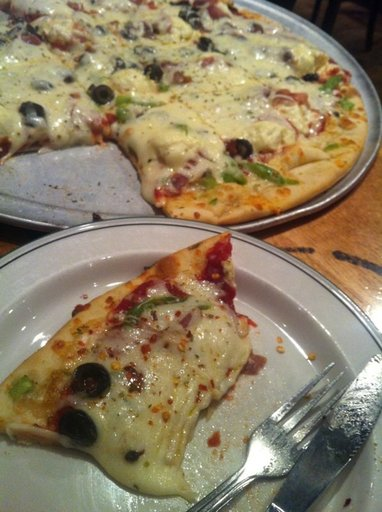

In [737]:
import random
from PIL import Image

random.seed(33)

image_path_list = list(image_path.glob('*/*/*.jpg'))


random_image_path = random.choice(image_path_list)
print(random_image_path)

image_class = random_image_path.parent.stem
print(image_class)

img = Image.open(random_image_path)

print(f'Image height: {img.height} | image width: {img.width}')
img

(-0.5, 381.5, 511.5, -0.5)

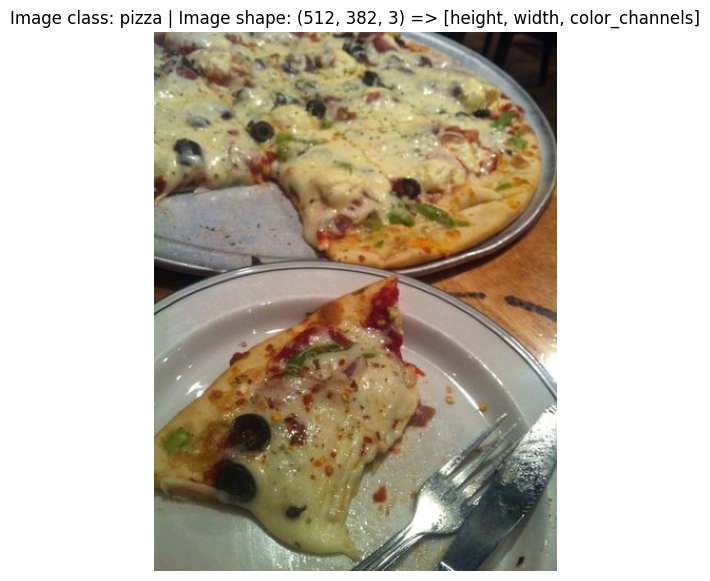

In [738]:
import numpy as np
import matplotlib.pyplot as plt

img_as_array = np.asarray(img)

plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f'Image class: {image_class} | Image shape: {img_as_array.shape} => [height, width, color_channels]')
plt.axis('off')

#3.0. Transform **data**

In [739]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [740]:
data_transform = transforms.Compose([
    #resize to 64x64
    transforms.Resize(size=(64, 64)),
    #Flip the images randomly on horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    #turrn image into a torch.Tensor
    transforms.ToTensor()
])

In [741]:
data_transform(img).shape

torch.Size([3, 64, 64])

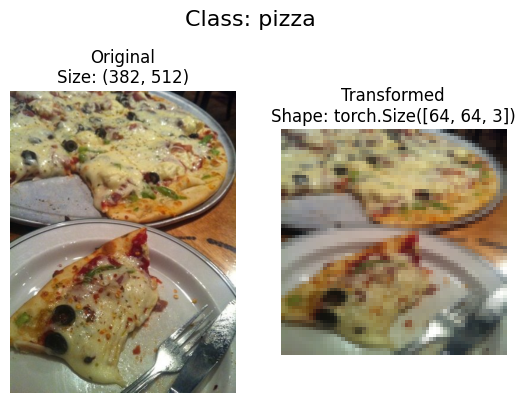

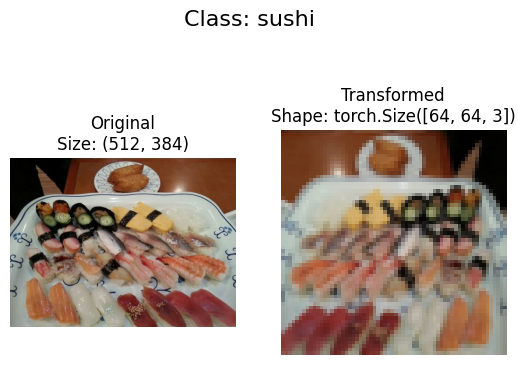

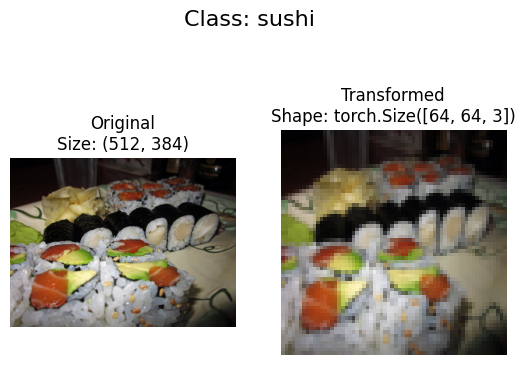

In [742]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax =plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f'Original\nSize: {f.size}')
      ax[0].axis('off')

      transformed_image = transform(f).permute(dims=[1, 2, 0])
      ax[1].imshow(transformed_image)
      ax[1].set_title(f'Transformed\nShape: {transformed_image.shape}')
      ax[1].axis('off')

      fig.suptitle(f'Class: {image_path.parent.stem}', fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                             transform=data_transform,
                             n=3,
                             seed=33)

#4.1. Loading data - ImageFolder

In [743]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [744]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [745]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [746]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [747]:
img, label = train_data[0][0], train_data[0][1]

In [748]:
img

tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0157, 0.0157, 0.

In [749]:
img.shape

torch.Size([3, 64, 64])

(-0.5, 63.5, 63.5, -0.5)

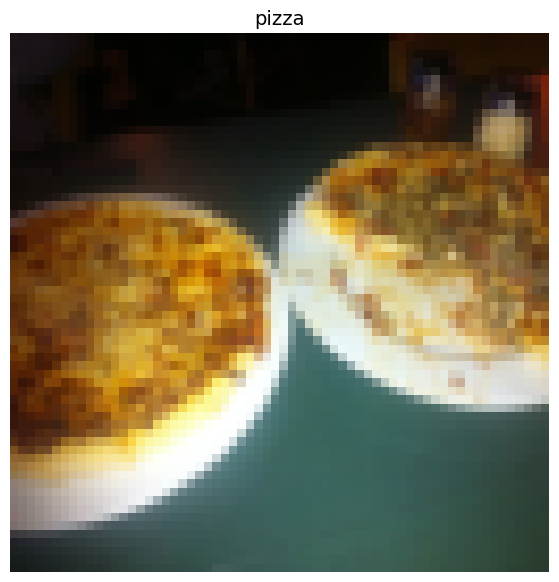

In [750]:
img_permuted = img.permute(1, 2, 0)

plt.figure(figsize=(10,7))
plt.imshow(img_permuted)
plt.title(class_names[label], fontsize=14)
plt.axis('off')

#4.2. DataLoader

In [751]:
import torch
from torch.utils.data import DataLoader

BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a687e3bd450>,
 <torch.utils.data.dataloader.DataLoader at 0x7a687e3bdc30>)

In [752]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [753]:
 img, label = next(iter(train_dataloader))

 print(f'Img shape {img.shape} and label shape {label.shape}')

Img shape torch.Size([1, 3, 64, 64]) and label shape torch.Size([1])


#5.1. Loading image data with custom dataset

In [754]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [755]:
target_directory = train_dir
print(f'Target dir: {target_directory}')

Target dir: data/pizza_steak_sushi/train


In [756]:
#get class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

['pizza', 'steak', 'sushi']

In [757]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  '''Finds the class folder names in a target directory'''
  #1 class names
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())
  #2 raise an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Could't find any classes in {directory}... please check file structure.")

  #3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [758]:
find_classes(target_directory)[0]

['pizza', 'steak', 'sushi']

In [759]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self,
               targ_dir: str,
               transform=None):
    self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:
    'Opens an Image cia a path and returns it'
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    return len(self.paths)

  def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
    'Returns one sample of data, data and label (X, y).'
    img = self.load_image(index)
    class_name = self.paths[index]. parent.name #expexts .jpg
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    return img, class_idx


In [760]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
                                      transforms.Resize(size=(64,64)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()
])

test_transforms = transforms.Compose([
                                      transforms.Resize(size=(64,64)),
                                      transforms.ToTensor
])

In [761]:
#Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7a687e3be200>,
 <__main__.ImageFolderCustom at 0x7a687e3bc160>)

In [762]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

# 5.2. Create a function to display random image

In [763]:
def display_random_images(dataset: torch.utils.data.Dataset,
                         classes: List[str] = None,
                         n: int = 10,
                         display_shape: bool = True,
                         seed: int = None):
  if n > 10:
    n = 10
    display_shape = False
    print(f'For display, purposese, n should not be larger than 10')

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16,8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    targ_image_adjust = targ_image.permute(1, 2, 0)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis('off')
    if classes:
      title = f'Class : {classes[targ_label]}'
      if display_shape:
        title = title + f'\nshape: {targ_image_adjust.shape}'

    plt.title(title)


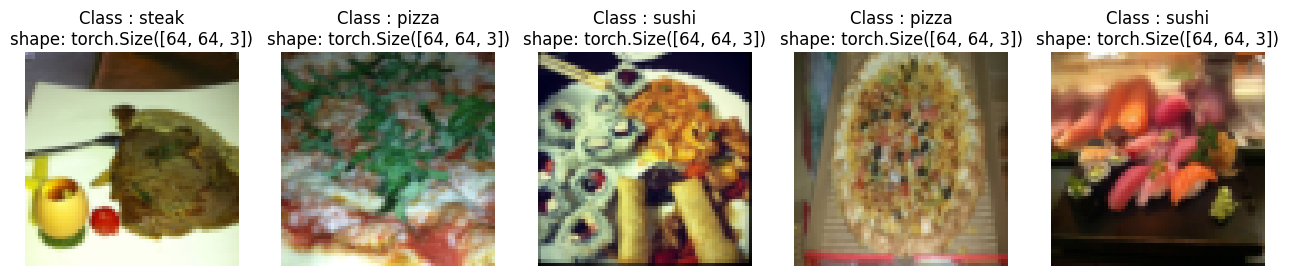

In [764]:
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=33)

For display, purposese, n should not be larger than 10


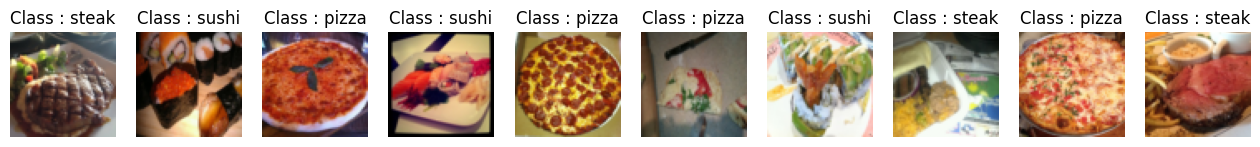

In [765]:
display_random_images(train_data_custom,
                      n=20,
                      classes=train_data_custom.classes,
                      seed=33)

5.3. Custom to DataLoader

In [766]:
import torch
from torch.utils.data import DataLoader

BATCH_SIZE=32
NUM_WORKERS = 0 #os.cpu_count()

train_custom_dataloader = DataLoader(
                                    dataset=train_data_custom,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=NUM_WORKERS
                                    )

test_custom_dataloader = DataLoader(
                                    dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS
                                    )

In [767]:
img_custom, label_custom = next(iter(train_custom_dataloader))
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

# 6.0. Model 0

In [768]:
simple_transform = transforms.Compose([
  transforms.Resize(size=(64,64)),
  transforms.ToTensor()
])

In [769]:
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

In [770]:
class TinyVGG(nn.Module):
  def __init__(self,
               input: int,
               hidden: int,
               out: int):
    super().__init__()
    self.conv_1 = nn.Sequential(
        nn.Conv2d(in_channels=input,
                 out_channels=hidden,
                 kernel_size=3,
                 stride=1,
                 padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden,
                 out_channels=hidden,
                 kernel_size=3,
                 stride=1,
                 padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                    stride=2)
    )
    self.conv_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden,
                 out_channels=hidden,
                 kernel_size=3,
                 stride=1,
                 padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden,
                 out_channels=hidden,
                 kernel_size=3,
                 stride=1,
                 padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                    stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden*13*13,
                  out_features=out)
    )

  def forward(self, x):
    x = self.conv_1(x)
    #print(x.shape)
    x = self.conv_2(x)
    #print(x.shape)
    x = self.classifier(x)
    return x




In [771]:
torch.manual_seed(33)
model_0 = TinyVGG(3, 10, len(class_names)).to(device)
model_0

TinyVGG(
  (conv_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

#6.1. Try a forward pass on a single image

In [772]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [773]:
model_0(image_batch)

tensor([[ 0.0229, -0.0232,  0.0029],
        [ 0.0220, -0.0238,  0.0039],
        [ 0.0258, -0.0214,  0.0003],
        [ 0.0241, -0.0236, -0.0014],
        [ 0.0243, -0.0218,  0.0012],
        [ 0.0253, -0.0192,  0.0044],
        [ 0.0240, -0.0245,  0.0026],
        [ 0.0261, -0.0201, -0.0017],
        [ 0.0237, -0.0195, -0.0007],
        [ 0.0257, -0.0197, -0.0023],
        [ 0.0248, -0.0212,  0.0061],
        [ 0.0248, -0.0206, -0.0024],
        [ 0.0301, -0.0213, -0.0010],
        [ 0.0253, -0.0249,  0.0003],
        [ 0.0259, -0.0251, -0.0003],
        [ 0.0275, -0.0204,  0.0035],
        [ 0.0250, -0.0237, -0.0019],
        [ 0.0274, -0.0187,  0.0010],
        [ 0.0222, -0.0220, -0.0020],
        [ 0.0200, -0.0253, -0.0009],
        [ 0.0233, -0.0201,  0.0037],
        [ 0.0248, -0.0238, -0.0035],
        [ 0.0270, -0.0237,  0.0019],
        [ 0.0229, -0.0258, -0.0011],
        [ 0.0282, -0.0199, -0.0002],
        [ 0.0224, -0.0239,  0.0026],
        [ 0.0239, -0.0235, -0.0007],
 

In [774]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

In [775]:
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

# 6.2. Creating train and test step function

In [776]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    #X, y = X.to(device), y.to(device)


    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #accuracy
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)


  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


In [777]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = device):

  #model.to(device)
  model.eval()

  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      loss = loss_fn(y_pred, y)
      test_loss += loss.item()

      #acc
      y_pred_class = y_pred.argmax(dim=1)
      test_acc += (y_pred_class == y).sum().item()/len(y_pred)

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

#6.3. Creating Train loop





In [778]:
def train(model:torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  results = {'train_loss': [],
             'train_acc': [],
             'test_loss': [],
             'test_acc': []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    print(f'Epoch: {epoch} | Train loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

  return results


# 6.4. Train and evaluate model_0

In [779]:
from timeit import default_timer as timer
from tqdm import tqdm
torch.manual_seed(33)
torch.cuda.manual_seed(33)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)
end_time = timer()

print(f'Total training time: {end_time-start_time:.3f} seconds')


 20%|██        | 1/5 [00:01<00:06,  1.75s/it]

Epoch: 0 | Train loss: 1.1030 | Train Acc: 0.2812 | Test loss: 1.1001 | Test Acc: 0.2604


 40%|████      | 2/5 [00:03<00:05,  1.77s/it]

Epoch: 1 | Train loss: 1.0942 | Train Acc: 0.4805 | Test loss: 1.1165 | Test Acc: 0.1979


 60%|██████    | 3/5 [00:05<00:03,  1.75s/it]

Epoch: 2 | Train loss: 1.1092 | Train Acc: 0.2930 | Test loss: 1.1272 | Test Acc: 0.1979


 80%|████████  | 4/5 [00:07<00:01,  1.77s/it]

Epoch: 3 | Train loss: 1.0993 | Train Acc: 0.3008 | Test loss: 1.0902 | Test Acc: 0.5748


100%|██████████| 5/5 [00:09<00:00,  1.84s/it]

Epoch: 4 | Train loss: 1.0742 | Train Acc: 0.5078 | Test loss: 1.0774 | Test Acc: 0.2812
Total training time: 9.209 seconds


In [780]:
def plot_loss_curves(results: Dict[str, List[float]]):
  loss = results['train_loss']
  test_loss = results['test_loss']

  accuracy = results['train_acc']
  test_accuracy = results['test_acc']

  epochs = range(len(results['train_loss']))

  plt.figure(figsize=(15,7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='train_acc')
  plt.plot(epochs, test_accuracy, label='test_acc')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

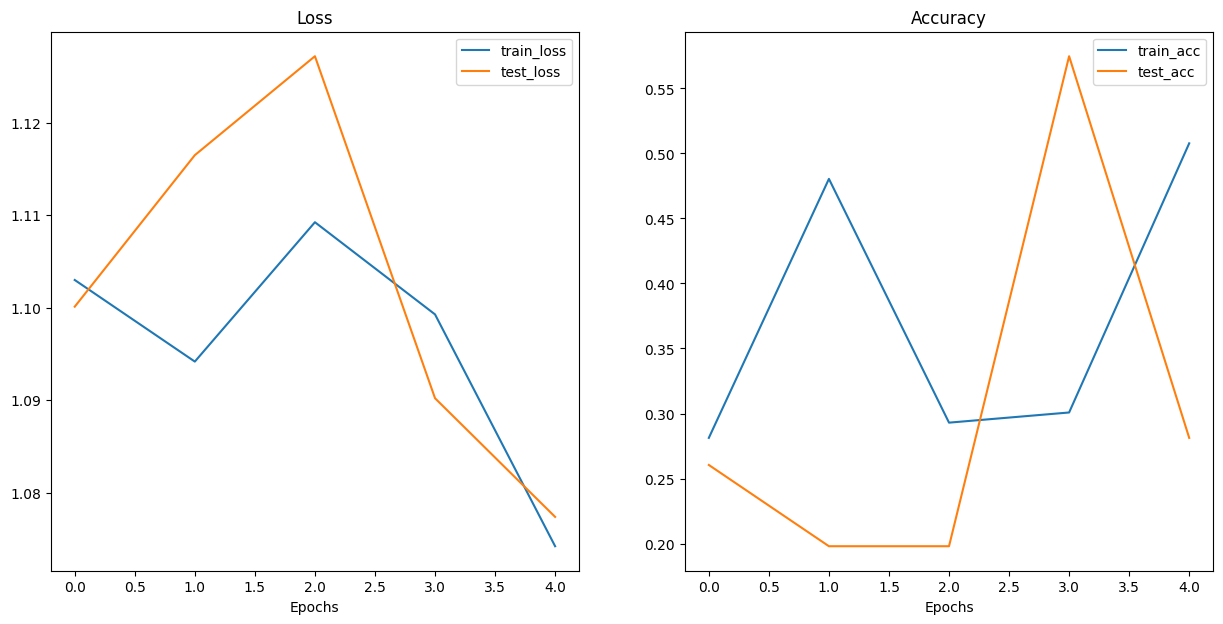

In [781]:
plot_loss_curves(model_0_results)

# 7.1. Model_1 with data augmentation

In [782]:
train_transform_trivial = transforms.Compose([
                                            transforms.Resize(size=(64, 64)),
                                            transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                            transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
                                            transforms.Resize(size=(64, 64)),
                                            transforms.ToTensor()
])

In [783]:
train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                            transform=test_transform_simple)

In [784]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(33)

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False,
                                        num_workers=NUM_WORKERS)

In [785]:
torch.manual_seed(33)
model_1 = TinyVGG(input=3,
                  hidden=10,
                  out=len(train_data_augmented.classes)).to(device)

model_1

TinyVGG(
  (conv_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [786]:
torch.manual_seed(33)
torch.cuda.manual_seed(33)

NUM_EPOCHS = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr=0.001)

model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS,
                        device=device)

 20%|██        | 1/5 [00:02<00:08,  2.04s/it]

Epoch: 0 | Train loss: 1.1029 | Train Acc: 0.2891 | Test loss: 1.1003 | Test Acc: 0.2604


 40%|████      | 2/5 [00:03<00:05,  1.93s/it]

Epoch: 1 | Train loss: 1.0949 | Train Acc: 0.4648 | Test loss: 1.1177 | Test Acc: 0.1979


 60%|██████    | 3/5 [00:05<00:03,  1.88s/it]

Epoch: 2 | Train loss: 1.1108 | Train Acc: 0.2930 | Test loss: 1.1287 | Test Acc: 0.1979


 80%|████████  | 4/5 [00:07<00:01,  1.84s/it]

Epoch: 3 | Train loss: 1.1012 | Train Acc: 0.2930 | Test loss: 1.1039 | Test Acc: 0.1979


100%|██████████| 5/5 [00:09<00:00,  1.86s/it]

Epoch: 4 | Train loss: 1.0909 | Train Acc: 0.4453 | Test loss: 1.0944 | Test Acc: 0.2604


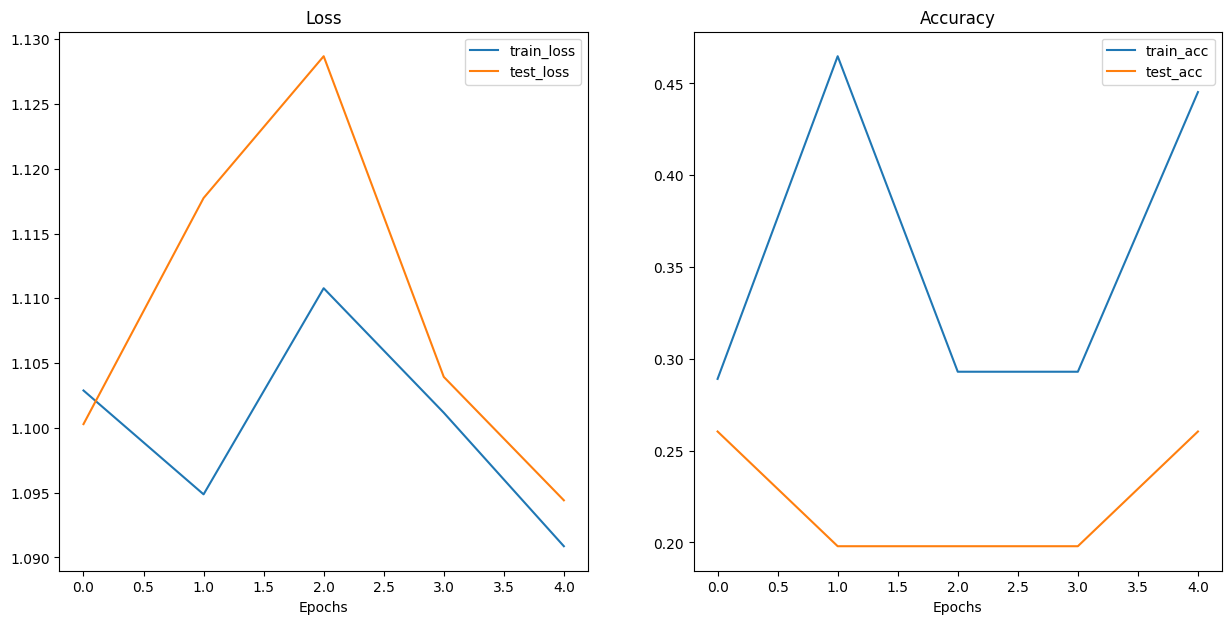

In [787]:
plot_loss_curves(model_1_results)

In [788]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

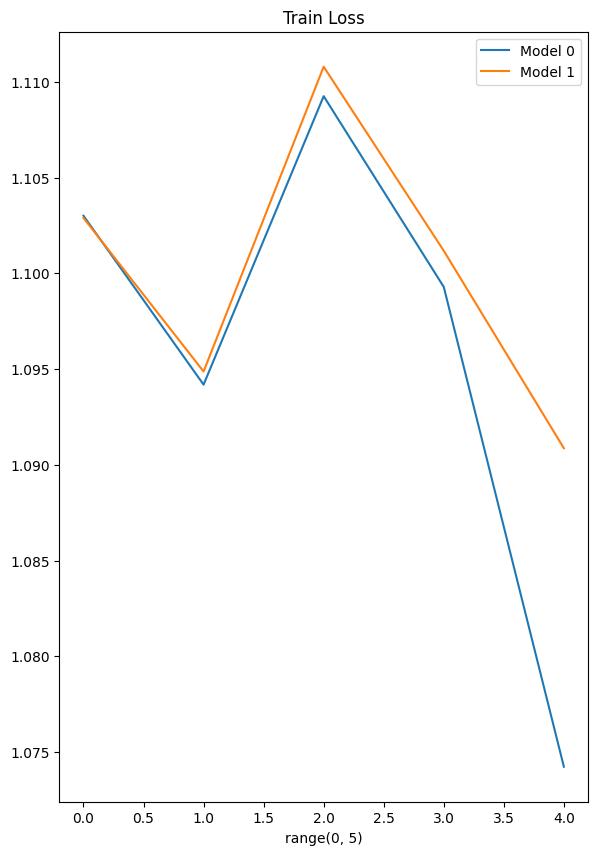

In [789]:
plt.figure(figsize=(15, 10))

epochs= range(len(model_0_df))

plt.subplot(1, 2, 1)
plt.plot(epochs, model_0_df['train_loss'], label='Model 0')
plt.plot(epochs, model_1_df['train_loss'], label='Model 1')
plt.title('Train Loss')
plt.xlabel(epochs)
plt.legend()

#8.1. Making predictions on a custom image

In [791]:
import requests

custom_image_path = data_path / '04-pizza-dad.jpeg'

if not custom_image_path.is_file():
  with open(custom_image_path, 'wb') as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f'Downloading {custom_image_path}...')
    f.write(request.content)
else:
  print('Already exists')

In [797]:
import torchvision

custom_image_unit8 = torchvision.io.read_image(str(custom_image_path))
custom_image_unit8.shape

torch.Size([3, 4032, 3024])

In [801]:
custom_image = custom_image_unit8.type(torch.float32)/255
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [804]:
custom_image_transform = transforms.Compose([
                                              transforms.Resize(size=(64, 64))
])

custom_image_transformed = custom_image_transform(custom_image)
custom_image_transformed.shape

torch.Size([3, 64, 64])

In [810]:
custom_image_transformed.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [808]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))

In [811]:
custom_image_pred.argmax(dim=1)

tensor([0])

In [813]:
train_data_augmented.classes[custom_image_pred.argmax(dim=1)]

'pizza'

In [818]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform = None,
                        device=device):
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  target_image = target_image / 255

  if transform:
    target_image = transform(target_image)

  model.to(device)

  model.eval()
  with torch.inference_mode():
    target_image = target_image.unsqueeze(0)

    target_image_pred = model(target_image.to(device))

  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)
  target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=1)

  plt.imshow(target_image.squeeze().permute(1, 2, 0))
  if class_names:
    title = f'Pred: {class_names[target_image_pred_labels.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}'
  else:
    title = f'Pred: {target_image_pred_labels} | Prob: {target_image_pred_probs.max().cpu():.3f}'
  plt.title(title)
  plt.axis('off')

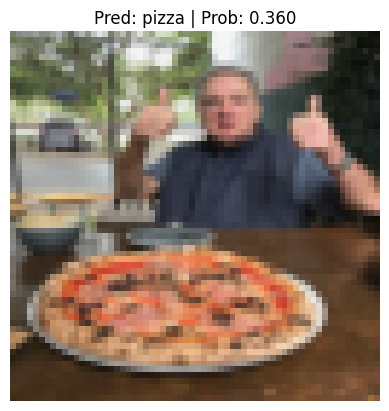

In [819]:
pred_and_plot_image(model=model_1,
                    image_path=str(custom_image_path),
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)